## Only UPDRS

Rerun the analysis done in [Linear SVC 1/5/2019](2019-01-05_LinearSVC_DataRoundup.ipynb) but this time use UPDRS as only feature:

For cross validation (need both mean and standard deviation) and holdout:
* Accuracy
* Sensitivity
* Specificity
* PPV
* NPV
* Recall
* Precision
* Area Under the Curve
* Support

Also need ROC curve as a list of numbers.

Variable contribution (importance) to models (mean and standard deviation).


**In addition**, look into how to change the threshold for probability scoring

## Imports and Function Definitions

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=verbose)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    
    get_metrics(clf.best_estimator_, Xh, yh)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))

## Define classifier, pipeline and constants

In [16]:
param_grid = {
    "classifier__C": np.logspace(-5, 2, 20),
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),\n",
#     ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True))
])

_cv=5
_test_size=0.20
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score)
}
_scoring='f1_micro'
_data = pd.read_excel('training_data_1004.xlsx')
_data = _data[['GroupID','UPDRS']]

## 1. Control vs. PD/MSA/PSP

In [17]:
# Get the data
data1 = group_classes(_data, {0:0, 1:1, 2:1, 3:1})

y1 = data1['GroupID']
X1 = data1.drop(['GroupID'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=_test_size, random_state=42)

best1 = grid_search_optimization(clf, param_grid, X_train1, Y_train1, X_test1, Y_test1, cv=_cv, scoring=_scoring, verbose=1)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    7.5s remaining:    1.2s


Best parameters set found on development set:

{'classifier__C': 0.6158482110660255}

Grid scores on development set:

0.542 (+/-0.424) for {'classifier__C': 1.0000000000000001e-05}
0.542 (+/-0.424) for {'classifier__C': 2.3357214690901213e-05}
0.716 (+/-0.004) for {'classifier__C': 5.4555947811685143e-05}
0.542 (+/-0.424) for {'classifier__C': 0.00012742749857031334}
0.458 (+/-0.424) for {'classifier__C': 0.00029763514416313193}
0.407 (+/-0.184) for {'classifier__C': 0.00069519279617756048}
0.615 (+/-0.064) for {'classifier__C': 0.001623776739188721}
0.806 (+/-0.051) for {'classifier__C': 0.0037926901907322499}
0.880 (+/-0.060) for {'classifier__C': 0.0088586679041008226}
0.918 (+/-0.054) for {'classifier__C': 0.02069138081114788}
0.933 (+/-0.045) for {'classifier__C': 0.048329302385717518}
0.930 (+/-0.051) for {'classifier__C': 0.11288378916846883}
0.935 (+/-0.043) for {'classifier__C': 0.26366508987303555}
0.939 (+/-0.038) for {'classifier__C': 0.6158482110660255}
0.939 (+/-0.038) f

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.7s finished


In [18]:
scores = cross_validate(best1.best_estimator_, X_train1, Y_train1, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.00770845413208	0.00067175700532
score_time	0.00529289245605	0.00169829416813
test_recall	0.932173913043	0.0271660858292
train_recall	0.928260869565	0.00869565217391
test_precision	0.98173676275	0.00566250648837
train_precision	0.981605665336	0.00147898243768
test_auc	0.944202898551	0.0138690259143
train_auc	0.942203454659	0.0051437274701
test_specificity	0.98173676275	0.00566250648837
train_specificity	0.981605665336	0.00147898243768
test_npv	0.932173913043	0.0271660858292
train_npv	0.928260869565	0.00869565217391
test_accuracy	0.938982919255	0.0190004063417
train_accuracy	0.936178253223	0.00659357690655


In [20]:
model = best1.best_estimator_.named_steps['classifier']
feature_names = data1.columns.tolist()[1:]
# plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

UPDRS	3.19448031647


             precision    recall  f1-score   support

          0       0.92      0.94      0.93        50
          1       0.98      0.97      0.98       151

avg / total       0.97      0.97      0.97       201



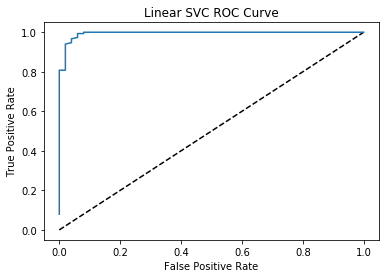

0.0 0.0794701986755
0.0 0.0927152317881
0.0 0.105960264901
0.0 0.112582781457
0.0 0.132450331126
0.0 0.139072847682
0.0 0.165562913907
0.0 0.185430463576
0.0 0.198675496689
0.0 0.278145695364
0.0 0.291390728477
0.0 0.304635761589
0.0 0.317880794702
0.0 0.324503311258
0.0 0.364238410596
0.0 0.390728476821
0.0 0.41059602649
0.0 0.423841059603
0.0 0.430463576159
0.0 0.456953642384
0.0 0.46357615894
0.0 0.490066225166
0.0 0.503311258278
0.0 0.516556291391
0.0 0.53642384106
0.0 0.562913907285
0.0 0.569536423841
0.0 0.602649006623
0.0 0.609271523179
0.0 0.635761589404
0.0 0.64238410596
0.0 0.668874172185
0.0 0.688741721854
0.0 0.701986754967
0.0 0.715231788079
0.0 0.735099337748
0.0 0.741721854305
0.0 0.761589403974
0.0 0.788079470199
0.0 0.794701986755
0.0 0.807947019868
0.02 0.807947019868
0.02 0.87417218543
0.02 0.887417218543
0.02 0.927152317881
0.02 0.940397350993
0.04 0.94701986755
0.04 0.953642384106
0.04 0.966887417219
0.06 0.973509933775
0.06 0.993377483444
0.08 0.993377483444
0.08 

In [21]:
plot_roc(best1.best_estimator_, X_test1, Y_test1)

## 2. PD vs MSA/PSP

In [22]:
# Get the data
data2 = group_classes(_data, {1:0, 2:1, 3:1})

y2 = data2['GroupID']
X2 = data2.drop(['GroupID'], axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=_test_size, random_state=42)

best2 = grid_search_optimization(clf, param_grid, X_train2, Y_train2, X_test2, Y_test2, cv=_cv, scoring=_scoring, verbose=1)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    7.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.0s finished


Best parameters set found on development set:

{'classifier__C': 0.0088586679041008226}

Grid scores on development set:

0.540 (+/-0.396) for {'classifier__C': 1.0000000000000001e-05}
0.622 (+/-0.321) for {'classifier__C': 2.3357214690901213e-05}
0.540 (+/-0.396) for {'classifier__C': 5.4555947811685143e-05}
0.540 (+/-0.396) for {'classifier__C': 0.00012742749857031334}
0.298 (+/-0.005) for {'classifier__C': 0.00029763514416313193}
0.378 (+/-0.321) for {'classifier__C': 0.00069519279617756048}
0.738 (+/-0.035) for {'classifier__C': 0.001623776739188721}
0.740 (+/-0.041) for {'classifier__C': 0.0037926901907322499}
0.747 (+/-0.037) for {'classifier__C': 0.0088586679041008226}
0.728 (+/-0.037) for {'classifier__C': 0.02069138081114788}
0.728 (+/-0.037) for {'classifier__C': 0.048329302385717518}
0.724 (+/-0.032) for {'classifier__C': 0.11288378916846883}
0.721 (+/-0.053) for {'classifier__C': 0.26366508987303555}
0.722 (+/-0.052) for {'classifier__C': 0.6158482110660255}
0.722 (+/-0.052

In [23]:
scores = cross_validate(best2.best_estimator_, X_train2, Y_train2, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0125095844269	0.000775870647606
score_time	0.00509724617004	0.000580498285819
test_recall	0.576806722689	0.0979265298776
train_recall	0.576530080284	0.0182126983062
test_precision	0.576790590505	0.0393151761026
train_precision	0.570857773196	0.00781997691542
test_auc	0.697542174955	0.0360569553697
train_auc	0.696130070817	0.00730177320705
test_specificity	0.576790590505	0.0393151761026
train_specificity	0.570857773196	0.00781997691542
test_npv	0.576806722689	0.0979265298776
train_npv	0.576530080284	0.0182126983062
test_accuracy	0.746506874768	0.0183933575364
train_accuracy	0.74439374483	0.00456291046807


In [24]:
model = best2.best_estimator_.named_steps['classifier']
feature_names = data2.columns.tolist()[1:]
# plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

UPDRS	0.744486065883


             precision    recall  f1-score   support

          0       0.82      0.73      0.77       107
          1       0.43      0.56      0.49        39

avg / total       0.72      0.68      0.70       146



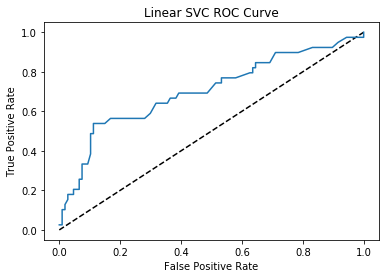

0.0 0.025641025641
0.00934579439252 0.025641025641
0.00934579439252 0.102564102564
0.018691588785 0.102564102564
0.018691588785 0.128205128205
0.0280373831776 0.153846153846
0.0280373831776 0.179487179487
0.0467289719626 0.179487179487
0.0467289719626 0.205128205128
0.0654205607477 0.205128205128
0.0654205607477 0.25641025641
0.0747663551402 0.25641025641
0.0747663551402 0.282051282051
0.0747663551402 0.333333333333
0.0934579439252 0.333333333333
0.102803738318 0.384615384615
0.102803738318 0.435897435897
0.102803738318 0.487179487179
0.11214953271 0.487179487179
0.11214953271 0.538461538462
0.121495327103 0.538461538462
0.140186915888 0.538461538462
0.14953271028 0.538461538462
0.168224299065 0.564102564103
0.224299065421 0.564102564103
0.233644859813 0.564102564103
0.252336448598 0.564102564103
0.280373831776 0.564102564103
0.299065420561 0.589743589744
0.317757009346 0.641025641026
0.327102803738 0.641025641026
0.345794392523 0.641025641026
0.355140186916 0.641025641026
0.3644859813

In [25]:
plot_roc(best2.best_estimator_, X_test2, Y_test2)

## 3. MSA vs PD/PSP

In [26]:
# Get the data
data3 = group_classes(_data, {1:0, 3:0, 2:1})

y3 = data3['GroupID']
X3 = data3.drop(['GroupID'], axis=1)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, y3, test_size=_test_size, random_state=42)

best3 = grid_search_optimization(clf, param_grid, X_train3, Y_train3, X_test3, Y_test3, cv=_cv, scoring=_scoring, verbose=1)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s


Best parameters set found on development set:

{'classifier__C': 2.3357214690901213e-05}

Grid scores on development set:

0.578 (+/-0.739) for {'classifier__C': 1.0000000000000001e-05}
0.878 (+/-0.006) for {'classifier__C': 2.3357214690901213e-05}
0.878 (+/-0.006) for {'classifier__C': 5.4555947811685143e-05}
0.878 (+/-0.006) for {'classifier__C': 0.00012742749857031334}
0.272 (+/-0.603) for {'classifier__C': 0.00029763514416313193}
0.276 (+/-0.599) for {'classifier__C': 0.00069519279617756048}
0.828 (+/-0.030) for {'classifier__C': 0.001623776739188721}
0.776 (+/-0.037) for {'classifier__C': 0.0037926901907322499}
0.755 (+/-0.046) for {'classifier__C': 0.0088586679041008226}
0.752 (+/-0.047) for {'classifier__C': 0.02069138081114788}
0.755 (+/-0.053) for {'classifier__C': 0.048329302385717518}
0.759 (+/-0.051) for {'classifier__C': 0.11288378916846883}
0.757 (+/-0.056) for {'classifier__C': 0.26366508987303555}
0.759 (+/-0.051) for {'classifier__C': 0.6158482110660255}
0.759 (+/-0.05

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.8s finished
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in longlong_scalars


In [30]:
scores = cross_validate(best3.best_estimator_, X_train3, Y_train3, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0121848106384	0.000757633990658
score_time	0.00671458244324	0.00123901061089
test_recall	0.0	0.0
train_recall	0.0	0.0
test_precision	0.0	0.0
train_precision	0.0	0.0
test_auc	0.5	0.0
train_auc	0.5	0.0
test_specificity	nan	nan
train_specificity	nan	nan
test_npv	0.0	0.0
train_npv	0.0	0.0
test_accuracy	0.877597355169	0.00292957557924
train_accuracy	0.877586909621	0.00073850541077


C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and bein

In [31]:
model = best3.best_estimator_.named_steps['classifier']
feature_names = data3.columns.tolist()[1:]
# plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

UPDRS	0.00757293697819


             precision    recall  f1-score   support

          0       0.92      1.00      0.96       134
          1       0.00      0.00      0.00        12

avg / total       0.84      0.92      0.88       146



C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


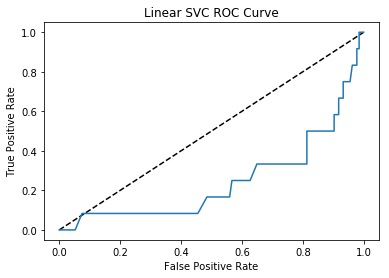

0.0 0.0
0.00746268656716 0.0
0.0223880597015 0.0
0.0298507462687 0.0
0.044776119403 0.0
0.0522388059701 0.0
0.0746268656716 0.0833333333333
0.119402985075 0.0833333333333
0.149253731343 0.0833333333333
0.194029850746 0.0833333333333
0.201492537313 0.0833333333333
0.216417910448 0.0833333333333
0.223880597015 0.0833333333333
0.246268656716 0.0833333333333
0.253731343284 0.0833333333333
0.283582089552 0.0833333333333
0.291044776119 0.0833333333333
0.305970149254 0.0833333333333
0.350746268657 0.0833333333333
0.39552238806 0.0833333333333
0.425373134328 0.0833333333333
0.455223880597 0.0833333333333
0.485074626866 0.166666666667
0.492537313433 0.166666666667
0.514925373134 0.166666666667
0.559701492537 0.166666666667
0.567164179104 0.25
0.582089552239 0.25
0.597014925373 0.25
0.60447761194 0.25
0.619402985075 0.25
0.626865671642 0.25
0.649253731343 0.333333333333
0.671641791045 0.333333333333
0.694029850746 0.333333333333
0.708955223881 0.333333333333
0.716417910448 0.333333333333
0.76119

In [32]:
plot_roc(best3.best_estimator_, X_test3, Y_test3)

## 4. PSP vs PD/MSA

In [33]:
# Get the data
data4 = group_classes(_data, {1:0, 2:0, 3:1})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=42)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring, verbose=1)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    7.5s remaining:    1.2s


Best parameters set found on development set:

{'classifier__C': 0.001623776739188721}

Grid scores on development set:

0.693 (+/-0.521) for {'classifier__C': 1.0000000000000001e-05}
0.434 (+/-0.635) for {'classifier__C': 2.3357214690901213e-05}
0.434 (+/-0.635) for {'classifier__C': 5.4555947811685143e-05}
0.693 (+/-0.521) for {'classifier__C': 0.00012742749857031334}
0.566 (+/-0.635) for {'classifier__C': 0.00029763514416313193}
0.566 (+/-0.635) for {'classifier__C': 0.00069519279617756048}
0.822 (+/-0.008) for {'classifier__C': 0.001623776739188721}
0.762 (+/-0.124) for {'classifier__C': 0.0037926901907322499}
0.707 (+/-0.100) for {'classifier__C': 0.0088586679041008226}
0.690 (+/-0.103) for {'classifier__C': 0.02069138081114788}
0.676 (+/-0.062) for {'classifier__C': 0.048329302385717518}
0.684 (+/-0.091) for {'classifier__C': 0.11288378916846883}
0.684 (+/-0.091) for {'classifier__C': 0.26366508987303555}
0.684 (+/-0.091) for {'classifier__C': 0.6158482110660255}
0.679 (+/-0.105)

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.9s finished
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [34]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0134112358093	0.00173757940819
score_time	0.00608777999878	0.000740771766315
test_recall	0.0	0.0
train_recall	0.0	0.0
test_precision	0.0	0.0
train_precision	0.0	0.0
test_auc	0.498947368421	0.00210526315789
train_auc	0.499738903394	0.000522193211488
test_specificity	nan	nan
train_specificity	nan	nan
test_npv	0.0	0.0
train_npv	0.0	0.0
test_accuracy	0.822418021758	0.00381310087509
train_accuracy	0.82370902875	0.00131638980291


C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and bein

ValueError: shape mismatch: objects cannot be broadcast to a single shape

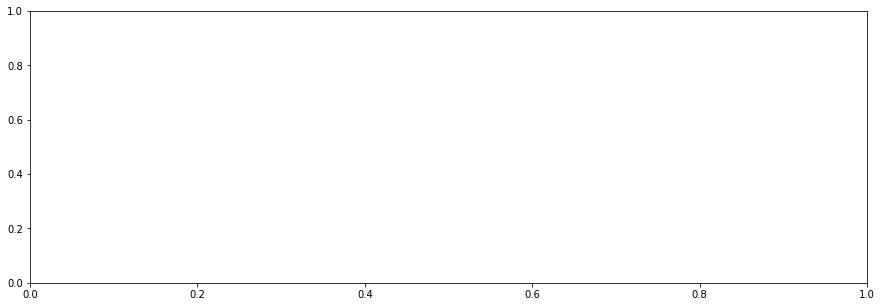

In [35]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       119
          1       0.18      1.00      0.31        27

avg / total       0.03      0.18      0.06       146



C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


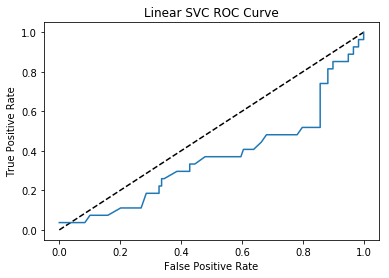

0.0 0.037037037037
0.0168067226891 0.037037037037
0.0252100840336 0.037037037037
0.0420168067227 0.037037037037
0.0504201680672 0.037037037037
0.0840336134454 0.037037037037
0.100840336134 0.0740740740741
0.126050420168 0.0740740740741
0.159663865546 0.0740740740741
0.201680672269 0.111111111111
0.210084033613 0.111111111111
0.226890756303 0.111111111111
0.235294117647 0.111111111111
0.260504201681 0.111111111111
0.268907563025 0.111111111111
0.285714285714 0.185185185185
0.294117647059 0.185185185185
0.310924369748 0.185185185185
0.327731092437 0.185185185185
0.327731092437 0.222222222222
0.336134453782 0.222222222222
0.336134453782 0.259259259259
0.344537815126 0.259259259259
0.386554621849 0.296296296296
0.420168067227 0.296296296296
0.428571428571 0.296296296296
0.428571428571 0.333333333333
0.445378151261 0.333333333333
0.478991596639 0.37037037037
0.487394957983 0.37037037037
0.512605042017 0.37037037037
0.579831932773 0.37037037037
0.596638655462 0.37037037037
0.605042016807 0.4

In [36]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)